<a href="https://colab.research.google.com/github/ppunkz/Portfoliobuilding/blob/master/Anomaly_Detection_in_Time_series_for_TESLA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np 
import tensorflow as tf 
import pandas as pd 
pd.options.mode.chained_assignment = None 
import seaborn as sns 
from matplotlib.pylab import rcParams 
import matplotlib.pyplot as plt
import plotly.express as px 
import plotly.graph_objects as go
import pandas_datareader as web

%matplotlib inline 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
tickers = ['GOOGL','FB','AAPL','NFLX','AMZN']
thelen = len(tickers)
price_data = []
for ticker in range(thelen):
   prices = web.DataReader(tickers[ticker], start='2018-06-20', end = '2020-06-20', data_source='yahoo')
   price_data.append(prices[['Adj Close']])
df_stocks = pd.concat(price_data, axis=1)
df_stocks.columns=tickers
df_stocks.tail()

In [27]:
df = web.DataReader('TSLA', start='2015-06-20', end = '2020-06-20', data_source='yahoo')
df = df.loc[:,('Adj Close')]
df = pd.DataFrame(df)
df = df.reset_index()
df.columns = ['date', 'close']

In [28]:
df

,date,close
0,2015-06-22,259.790009
1,2015-06-23,267.670013
2,2015-06-24,265.170013
3,2015-06-25,268.790009
4,2015-06-26,267.089996
...,...,...
1254,2020-06-15,990.900024
1255,2020-06-16,982.130005
1256,2020-06-17,991.789978
1257,2020-06-18,1003.960022


In [ ]:
#df = pd.read_csv('goldprice.csv', parse_dates=['Date']) 
#df.columns = ['date','close']
#df.head()

,date,close
0,2000-08-30,273.899994
1,2000-08-31,278.299988
2,2000-09-01,277.000000
3,2000-09-05,275.799988
4,2000-09-06,274.200012


In [31]:
fig = go.Figure() 
fig.add_trace(go.Scatter(x=df.date, y=df.close, mode='lines', name='close')) 
fig.update_layout(showlegend=True)
fig.update_layout(title='Tesla historical stock prices')
fig.show()

In [32]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)] 
print(train.shape, test.shape)

(1007, 2) (252, 2)


In [33]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler() 
scaler = scaler.fit(train[['close']]) 
train['close'] = scaler.transform(train[['close']]) 
test['close'] = scaler.transform(test[['close']])

In [34]:
def create_dataset(X, y, time_steps=1): 
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values 
        Xs.append(v)    
        ys.append(y.iloc[i + time_steps]) 
    return np.array(Xs), np.array(ys)

In [35]:
time_steps = 30 
X_train, y_train = create_dataset(train[['close']], train.close, time_steps) 
X_test, y_test = create_dataset(test[['close']], test.close, time_steps) 
print(X_train.shape)

(977, 30, 1)


In [36]:
print(X_test.shape)

(222, 30, 1)


In [37]:
timesteps = X_train.shape[1] 
num_features = X_train.shape[2]
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed 
model = Sequential([ LSTM(64, return_sequences=False, input_shape=(timesteps, num_features)), 
                    Dropout(0.1), 
                    RepeatVector(timesteps), 
                    LSTM(64, return_sequences=True), 
                    Dropout(0.1), 
                    TimeDistributed(Dense(num_features))]) 
model.compile(loss='mae', optimizer='adam') 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 64)            33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
____________________________________________________

In [40]:
#es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min') 
#history = model.fit( X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks = [es], shuffle=False )
history = model.fit( X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, shuffle=False )

Epoch 1/100
28/28 [==============================] - 1s 28ms/step - loss: 0.2266 - val_loss: 0.1861
Epoch 2/100
28/28 [==============================] - 1s 27ms/step - loss: 0.1834 - val_loss: 0.1561
Epoch 3/100
28/28 [==============================] - 1s 27ms/step - loss: 0.1696 - val_loss: 0.1481
Epoch 4/100
28/28 [==============================] - 1s 28ms/step - loss: 0.1614 - val_loss: 0.1409
Epoch 5/100
28/28 [==============================] - 1s 27ms/step - loss: 0.1555 - val_loss: 0.1352
Epoch 6/100
28/28 [==============================] - 1s 27ms/step - loss: 0.1493 - val_loss: 0.1387
Epoch 7/100
28/28 [==============================] - 1s 27ms/step - loss: 0.1475 - val_loss: 0.1426
Epoch 8/100
28/28 [==============================] - 1s 27ms/step - loss: 0.1490 - val_loss: 0.1822
Epoch 9/100
28/28 [==============================] - 1s 27ms/step - loss: 0.1773 - val_loss: 0.1778
Epoch 10/100
28/28 [==============================] - 1s 27ms/step - loss: 0.1917 - val_loss: 0.2047

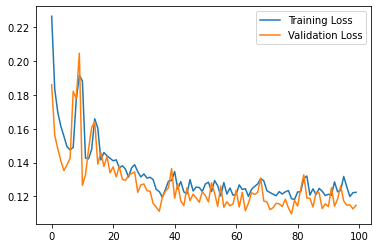

In [41]:
plt.plot(history.history['loss'], label='Training Loss') 
plt.plot(history.history['val_loss'], label='Validation Loss') 
plt.legend();

In [42]:
X_train_pred = model.predict(X_train) 
train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_pred - X_train), axis=1), columns=['Error'])
model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 7ms/step - loss: 2.2901


2.2901418209075928

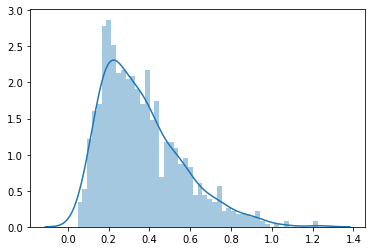

In [43]:
sns.distplot(train_mae_loss, bins=50, kde=True);

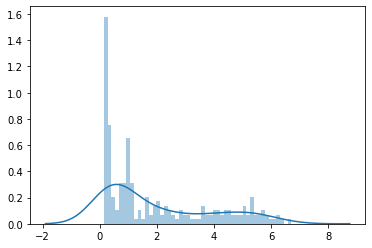

In [44]:
X_test_pred = model.predict(X_test) 
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)
sns.distplot(test_mae_loss, bins=50, kde=True);

In [45]:
THRESHOLD = 0.6
test_score_df = pd.DataFrame(test[time_steps:]) 
test_score_df['loss'] = test_mae_loss 
test_score_df['threshold'] = THRESHOLD 
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold 
test_score_df['close'] = test[time_steps:].close

In [46]:
test_mae_loss.shape

(222, 1)

In [47]:
test.shape

(252, 2)

In [48]:
test_score_df.head()

,date,close,loss,threshold,anomaly
1037,2019-08-05,-0.822128,0.202635,0.6,False
1038,2019-08-06,-0.778166,0.200429,0.6,False
1039,2019-08-07,-0.729863,0.190091,0.6,False
1040,2019-08-08,-0.641579,0.184669,0.6,False
1041,2019-08-09,-0.701099,0.190784,0.6,False


In [49]:
test_score_df.tail()

,date,close,loss,threshold,anomaly
1254,2020-06-15,12.973735,5.798213,0.6,True
1255,2020-06-16,12.815076,5.842248,0.6,True
1256,2020-06-17,12.989835,5.991025,0.6,True
1257,2020-06-18,13.210004,6.105654,0.6,True
1258,2020-06-19,13.154645,6.213474,0.6,True


In [50]:
fig = go.Figure() 
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=test_score_df.loss, mode='lines', name='Test Loss')) 
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=test_score_df.threshold, mode='lines', name='Threshold')) 
fig.update_layout(showlegend=True) 
fig.show()